# Textual Anomaly Detection in Financial Reports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv('creditcard_data.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284806 entries, 0 to 284805
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284806 non-null  float64
 1   V1      284806 non-null  float64
 2   V2      284806 non-null  float64
 3   V3      284806 non-null  float64
 4   V4      284806 non-null  float64
 5   V5      284806 non-null  float64
 6   V6      284806 non-null  float64
 7   V7      284806 non-null  float64
 8   V8      284806 non-null  float64
 9   V9      284806 non-null  float64
 10  V10     284806 non-null  float64
 11  V11     284806 non-null  float64
 12  V12     284806 non-null  float64
 13  V13     284806 non-null  float64
 14  V14     284806 non-null  float64
 15  V15     284806 non-null  float64
 16  V16     284806 non-null  float64
 17  V17     284806 non-null  float64
 18  V18     284806 non-null  float64
 19  V19     284806 non-null  float64
 20  V20     284806 non-null  float64
 21  V21     28

In [4]:
data1= data.sample(frac = 0.1,random_state=1)
data1.shape

(28481, 31)

In [5]:
# Checking the missing values 
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,284806.000000,284806.000000,...,2.848060e+05,284806.000000,284806.000000,2.848060e+05,284806.000000,284806.000000,2.848060e+05,2.848060e+05,284806.000000,284806.000000
mean,94813.585781,0.000002,6.661837e-07,-0.000002,0.000002,4.405008e-08,0.000002,-0.000006,0.000001,-0.000002,...,-9.166149e-07,-0.000002,-0.000001,-3.088756e-08,0.000002,0.000003,8.483873e-09,-4.792707e-08,88.349168,0.001727
std,47488.004530,1.958699,1.651311e+00,1.516257,1.415871,1.380249e+00,1.332273,1.237092,1.194355,1.098634,...,7.345251e-01,0.725702,0.624461,6.056481e-01,0.521278,0.482225,4.036332e-01,3.300838e-01,250.120432,0.041527
min,0.000000,-56.407510,-7.271573e+01,-48.325589,-5.683171,-1.137433e+02,-26.160506,-43.557242,-73.216718,-13.434066,...,-3.483038e+01,-10.933144,-44.807735,-2.836627e+00,-10.295397,-2.604551,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.250000,-0.920374,-5.985522e-01,-0.890368,-0.848642,-6.915995e-01,-0.768296,-0.554080,-0.208628,-0.643098,...,-2.283974e-01,-0.542351,-0.161846,-3.545895e-01,-0.317142,-0.326979,-7.083961e-02,-5.295995e-02,5.600000,0.000000
50%,84691.500000,0.018109,6.549621e-02,0.179846,-0.019845,-5.433621e-02,-0.274186,0.040097,0.022358,-0.051429,...,-2.945020e-02,0.006781,-0.011196,4.097671e-02,0.016596,-0.052134,1.342244e-03,1.124381e-02,22.000000,0.000000
75%,139320.000000,1.315645,8.037257e-01,1.027198,0.743348,6.119267e-01,0.398567,0.570426,0.327346,0.597140,...,1.863701e-01,0.528548,0.147641,4.395270e-01,0.350716,0.240955,9.104579e-02,7.828043e-02,77.160000,0.000000
max,172788.000000,2.454930,2.205773e+01,9.382558,16.875344,3.480167e+01,73.301626,120.589494,20.007208,15.594995,...,2.720284e+01,10.503090,22.528412,4.584549e+00,7.519589,3.517346,3.161220e+01,3.384781e+01,25691.160000,1.000000


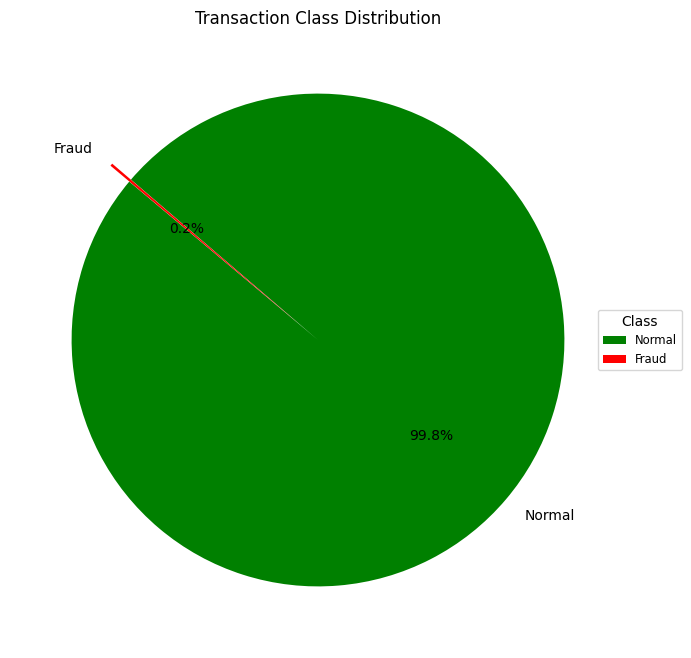

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data1 = {'Class': ['Normal', 'Fraud'], 'Count': [284315, 492]}
df = pd.DataFrame(data1)

# Plotting the pie chart with count in the legend
plt.figure(figsize=(8, 8))
colors = ['green', 'red']
explode = (0, 0.1)  # Explode the second slice (Fraud) for emphasis
plt.pie(df['Count'], labels=df['Class'], colors=colors, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title("Transaction Class Distribution")
plt.legend(title="Class", loc="right", fontsize='small', bbox_to_anchor=(1.1, 0.5))
plt.show()


In [8]:
#Assigning the transaction class "0 = NORMAL  & 1 = FRAUD"
Normal = data[data['Class'] == 0]
Fraud  = data[data['Class'] == 1]

In [9]:
Normal.shape

(284314, 31)

In [10]:
Fraud.shape

(492, 31)

In [11]:
Fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

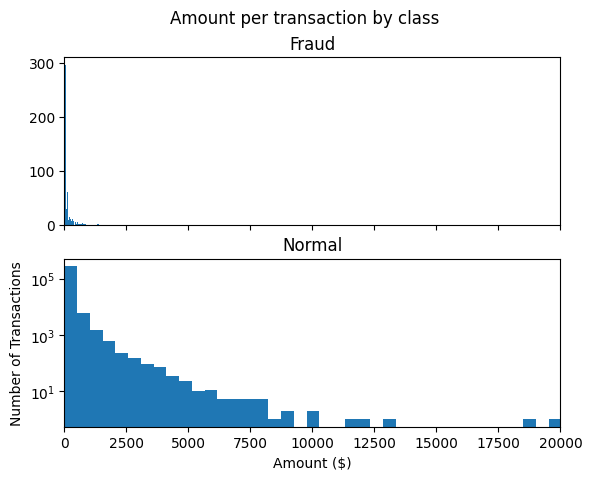

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

AutoEncoder architecture

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the credit card data
data = pd.read_csv('creditcard_data.csv')
data.head()

# Separate features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the Autoencoder model for anomaly detection
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x

# Set hyperparameters
input_dim = X_train_tensor.shape[1]
encoding_dim = 20  # Adjust as needed

# Initialize the model, loss function, and optimizer
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
batch_size = 64
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch = X_train_tensor[i:i + batch_size]
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(model.state_dict(), 'credit_card_autoencoder_model.pth')

# Apply the trained model to detect anomalies in test data
model.eval()
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    test_loss = criterion(reconstructed, X_test_tensor)
    print(f"Test Loss: {test_loss.item()}")


Epoch 1/10, Loss: 0.4886162579059601
Epoch 2/10, Loss: 0.47369739413261414
Epoch 3/10, Loss: 0.472178190946579
Epoch 4/10, Loss: 0.4675658047199249
Epoch 5/10, Loss: 0.4617708623409271
Epoch 6/10, Loss: 0.46015745401382446
Epoch 7/10, Loss: 0.45916616916656494
Epoch 8/10, Loss: 0.45882999897003174
Epoch 9/10, Loss: 0.4586640000343323
Epoch 10/10, Loss: 0.45822519063949585
Test Loss: 0.682221531867981


In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [15]:

# Load the credit card data
data = pd.read_csv('creditcard_data.csv')
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:

# Separate features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the Autoencoder model for anomaly detection
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x


In [17]:
# Set hyperparameters
input_dim = X_train_tensor.shape[1]
encoding_dim = 20  # Adjust as needed

# Initialize the model, loss function, and optimizer
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
batch_size = 64
train_losses = []
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch = X_train_tensor[i:i + batch_size]
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(model.state_dict(), 'credit_card_autoencoder_model.pth')

Epoch 1/50, Loss: 0.4422624409198761
Epoch 2/50, Loss: 0.43068376183509827
Epoch 3/50, Loss: 0.4283224046230316
Epoch 4/50, Loss: 0.4314635694026947
Epoch 5/50, Loss: 0.43462327122688293
Epoch 6/50, Loss: 0.43598443269729614
Epoch 7/50, Loss: 0.4360208511352539
Epoch 8/50, Loss: 0.43040546774864197
Epoch 9/50, Loss: 0.43056219816207886
Epoch 10/50, Loss: 0.4299658536911011
Epoch 11/50, Loss: 0.4315403699874878
Epoch 12/50, Loss: 0.43338724970817566
Epoch 13/50, Loss: 0.4334515333175659
Epoch 14/50, Loss: 0.43383273482322693
Epoch 15/50, Loss: 0.43564119935035706
Epoch 16/50, Loss: 0.436891108751297
Epoch 17/50, Loss: 0.4368528127670288
Epoch 18/50, Loss: 0.4379409849643707
Epoch 19/50, Loss: 0.4391389489173889
Epoch 20/50, Loss: 0.43937453627586365
Epoch 21/50, Loss: 0.4402395784854889
Epoch 22/50, Loss: 0.44067680835723877
Epoch 23/50, Loss: 0.44051459431648254
Epoch 24/50, Loss: 0.4402989149093628
Epoch 25/50, Loss: 0.44044482707977295
Epoch 26/50, Loss: 0.4404776990413666
Epoch 27/5

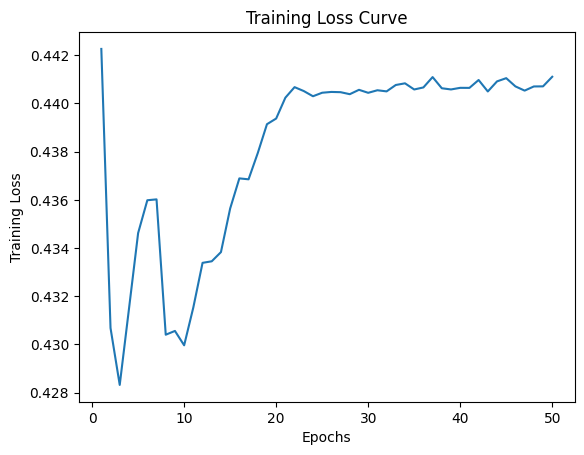

In [18]:
# Plotting the training loss curve
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

In [19]:
# Apply the trained model to detect anomalies in test data
model.eval()
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    test_loss = criterion(reconstructed, X_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.6766698360443115


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Convert PyTorch tensors to NumPy arrays
reconstruction_errors_np = reconstruction_errors.numpy()
y_pred_np = (reconstruction_errors_np > threshold).astype(int)
y_true_np = y_test_tensor.numpy().astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_np, y_pred_np)
precision = precision_score(y_true_np, y_pred_np)
recall = recall_score(y_true_np, y_pred_np)
f1 = f1_score(y_true_np, y_pred_np)
conf_matrix = confusion_matrix(y_true_np, y_pred_np)

print("Validation Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



Validation Results:
Accuracy: 0.9914328850812822
Precision: 0.11089108910891089
Recall: 0.5894736842105263
F1 Score: 0.18666666666666668


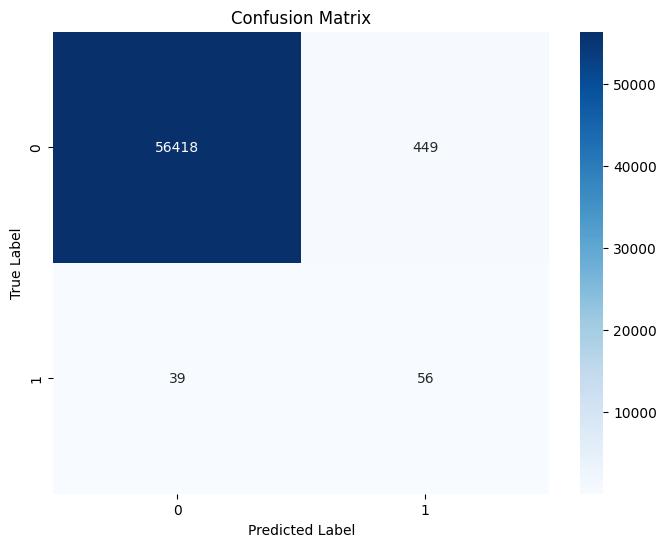

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_np, y_pred_np)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Anomaly detection on Test Dataset

In [21]:
# Calculate reconstruction errors for anomaly detection
reconstruction_errors = torch.mean((X_test_tensor - reconstructed)**2, dim=1)
mean_error = reconstruction_errors.mean().item()
std_error = reconstruction_errors.std().item()
threshold = mean_error + 2 * std_error  # Set the threshold for anomaly detection

# Create a new DataFrame to store the reconstruction errors
error_df = pd.DataFrame({'Reconstruction_Error': reconstruction_errors})

# Merge error_df with the original data on index to match rows
merged_data = data.merge(error_df, left_index=True, right_index=True)

# Detect anomalies in the test data based on reconstruction errors
anomalies = merged_data[merged_data['Reconstruction_Error'] > threshold]
print(f"Number of anomalies detected: {len(anomalies)}")
print(anomalies.head())


Number of anomalies detected: 505
      Time        V1        V2        V3        V4        V5        V6  \
0      0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
300  217.0 -2.421230 -1.369602  2.261281  2.011034  1.878525 -1.275607   
389  284.0  1.141436  0.081893  0.503625  1.487212 -0.473170 -0.411384   
459  336.0 -0.895224  0.562106  2.817524 -0.718734  0.223222  0.796156   
463  340.0  1.195494  0.194929  0.617510  0.649717 -0.474718 -0.716084   

           V7        V8        V9  ...       V22       V23       V24  \
0    0.239599  0.098698  0.363787  ...  0.277838 -0.110474  0.066928   
300 -1.251029  0.212619  0.142608  ...  0.157737 -0.624865  0.487156   
389 -0.053193  0.071036  0.553486  ... -0.150234  0.001322  0.369459   
459  0.464887 -0.002081  0.387537  ...  0.221249 -0.380422 -0.245721   
463 -0.027078 -0.073385  0.057251  ... -0.590119  0.210111  0.388014   

          V25       V26       V27       V28  Amount  Class  \
0    0.128539 -0.189115  0

# Deployment System

In [24]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display, clear_output

In [25]:
!pip install ipywidgets


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Load and preprocess your data
data = pd.read_csv('creditcard_data.csv')
scaler = StandardScaler()
X = data.drop('Class', axis=1)
y = data['Class']
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x

input_size = X_train.shape[1]
hidden_size = 20
model = Autoencoder(input_size, hidden_size)

# Train the autoencoder model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

threshold = 0.01

detected_anomalies = []

def detect_anomalies(*args):
    output_widget.clear_output()

    # Get input data from widgets
    input_data = [widget.value for widget in input_widgets]
    input_df = pd.DataFrame([input_data], columns=X.columns)
    input_data_scaled = scaler.transform(input_df.values)
    input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        reconstructed = model(input_tensor)
        reconstruction_error = torch.mean((input_tensor - reconstructed)**2).item()

    with output_widget:
        if reconstruction_error > threshold:
            print('Anomaly Detected!')
            # Print the detected anomaly
            print('Detected Anomaly Data:')
            print(input_df)
            # Add the anomaly to the list of detected anomalies
            detected_anomalies.append(input_df)
        else:
            print('No Anomaly Detected')

# Create input widgets
input_widgets = [widgets.FloatText(description=col) for col in X.columns]

# Create button to detect anomalies
detect_button = widgets.Button(description='Detect Anomaly')
detect_button.on_click(detect_anomalies)

# Create output widget
output_widget = widgets.Output()

# Display widgets
display(*input_widgets, detect_button, output_widget)

# Function to display only the anomalies
def display_anomalies():
    clear_output()
    print("Detected Anomalies:")
    for anomaly in detected_anomalies:
        print(anomaly)

# Create a button to show anomalies
show_anomalies_button = widgets.Button(description='Show Anomalies')
show_anomalies_button.on_click(lambda b: display_anomalies())

# Display the button
display(show_anomalies_button)


FloatText(value=0.0, description='Time')

FloatText(value=0.0, description='V1')

FloatText(value=0.0, description='V2')

FloatText(value=0.0, description='V3')

FloatText(value=0.0, description='V4')

FloatText(value=0.0, description='V5')

FloatText(value=0.0, description='V6')

FloatText(value=0.0, description='V7')

FloatText(value=0.0, description='V8')

FloatText(value=0.0, description='V9')

FloatText(value=0.0, description='V10')

FloatText(value=0.0, description='V11')

FloatText(value=0.0, description='V12')

FloatText(value=0.0, description='V13')

FloatText(value=0.0, description='V14')

FloatText(value=0.0, description='V15')

FloatText(value=0.0, description='V16')

FloatText(value=0.0, description='V17')

FloatText(value=0.0, description='V18')

FloatText(value=0.0, description='V19')

FloatText(value=0.0, description='V20')

FloatText(value=0.0, description='V21')

FloatText(value=0.0, description='V22')

FloatText(value=0.0, description='V23')

FloatText(value=0.0, description='V24')

FloatText(value=0.0, description='V25')

FloatText(value=0.0, description='V26')

FloatText(value=0.0, description='V27')

FloatText(value=0.0, description='V28')

FloatText(value=0.0, description='Amount')

Button(description='Detect Anomaly', style=ButtonStyle())

Output()

Button(description='Show Anomalies', style=ButtonStyle())

# Model 2

In [27]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

In [28]:
!pip install wordcloud


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import re
import ipywidgets as widgets
from IPython.display import display, clear_output
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [30]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
# Load your data
df = pd.read_csv('financial_anomaly_data.csv')
df.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [32]:
# Preprocess text data
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert text to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        
        # Tokenize text
        tokens = word_tokenize(text)
        
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        
        # Lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    return ''

df['Merchant'] = df['Merchant'].apply(preprocess_text)
df['TransactionType'] = df['TransactionType'].apply(preprocess_text)
df['Location'] = df['Location'].apply(preprocess_text)

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Merchant', 'TransactionType', 'Location'])

# Drop non-numeric columns before imputation
non_numeric_cols = ['Timestamp', 'TransactionID', 'AccountID']
df_numeric = df_encoded.drop(non_numeric_cols, axis=1)

# Impute missing values for numerical columns
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)


In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(column_data):
    # Join all the text in the column
    text = ' '.join(column_data)
    
    # Create WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axis
    plt.show()

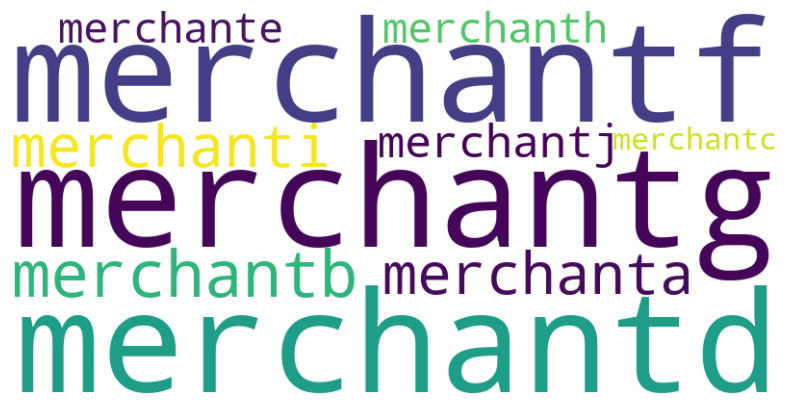

In [34]:
generate_word_cloud(df['Merchant'])

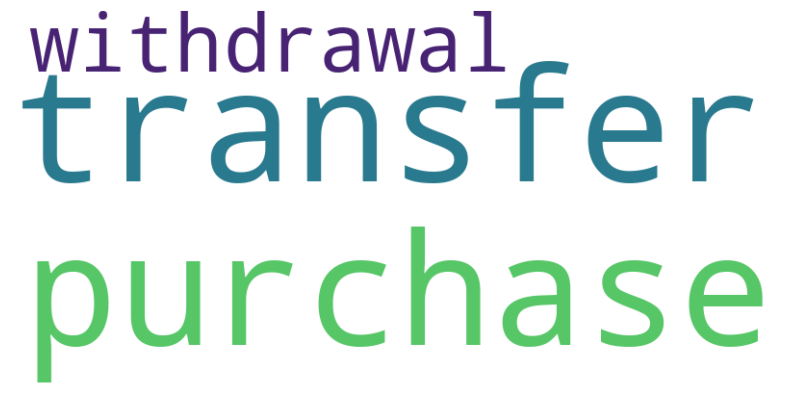

In [35]:
generate_word_cloud(df['TransactionType'])


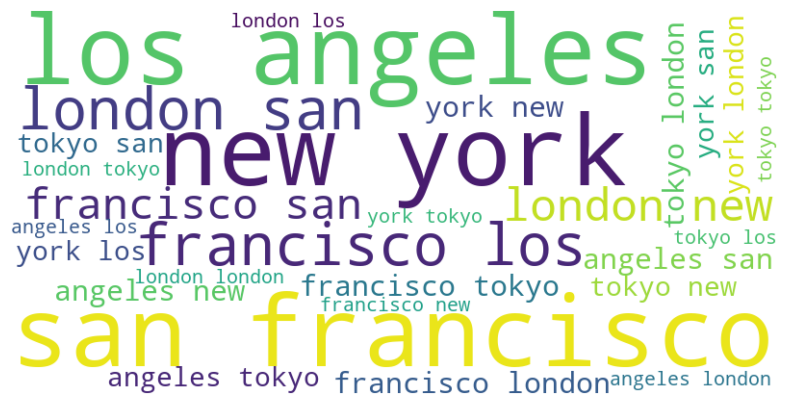

In [36]:
generate_word_cloud(df['Location'])

AutoEncoder

In [44]:
# Standardize numerical variables
scaler = StandardScaler()
num_cols = df_imputed.select_dtypes(include=['number']).columns.tolist()
df_imputed[num_cols] = scaler.fit_transform(df_imputed[num_cols])

# Perform PCA for feature selection
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df_imputed)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_imputed['Amount'], test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x

# Instantiate the autoencoder model
input_size = X_train_tensor.shape[1]
hidden_size = max(10, input_size // 2)  # Adjust hidden size based on input variables
model = Autoencoder(input_size, hidden_size)

# Train the autoencoder model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, X_train_tensor)
    train_losses.append(train_loss.item())
    train_loss.backward()
    optimizer.step()

    # Test the model using the test data
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, X_test_tensor)
        test_losses.append(test_loss.item())
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch 1/500, Train Loss: 1.5704, Test Loss: 1.5705
Epoch 2/500, Train Loss: 1.5690, Test Loss: 1.5691
Epoch 3/500, Train Loss: 1.5676, Test Loss: 1.5677
Epoch 4/500, Train Loss: 1.5663, Test Loss: 1.5664
Epoch 5/500, Train Loss: 1.5649, Test Loss: 1.5650
Epoch 6/500, Train Loss: 1.5636, Test Loss: 1.5637
Epoch 7/500, Train Loss: 1.5623, Test Loss: 1.5624
Epoch 8/500, Train Loss: 1.5609, Test Loss: 1.5610
Epoch 9/500, Train Loss: 1.5596, Test Loss: 1.5597
Epoch 10/500, Train Loss: 1.5583, Test Loss: 1.5584
Epoch 11/500, Train Loss: 1.5569, Test Loss: 1.5570
Epoch 12/500, Train Loss: 1.5556, Test Loss: 1.5557
Epoch 13/500, Train Loss: 1.5543, Test Loss: 1.5544
Epoch 14/500, Train Loss: 1.5529, Test Loss: 1.5531
Epoch 15/500, Train Loss: 1.5516, Test Loss: 1.5517
Epoch 16/500, Train Loss: 1.5503, Test Loss: 1.5504
Epoch 17/500, Train Loss: 1.5490, Test Loss: 1.5491
Epoch 18/500, Train Loss: 1.5477, Test Loss: 1.5478
Epoch 19/500, Train Loss: 1.5463, Test Loss: 1.5464
Epoch 20/500, Train L

Epoch 160/500, Train Loss: 1.3098, Test Loss: 1.3088
Epoch 161/500, Train Loss: 1.3081, Test Loss: 1.3071
Epoch 162/500, Train Loss: 1.3064, Test Loss: 1.3055
Epoch 163/500, Train Loss: 1.3047, Test Loss: 1.3038
Epoch 164/500, Train Loss: 1.3031, Test Loss: 1.3021
Epoch 165/500, Train Loss: 1.3014, Test Loss: 1.3004
Epoch 166/500, Train Loss: 1.2997, Test Loss: 1.2988
Epoch 167/500, Train Loss: 1.2981, Test Loss: 1.2971
Epoch 168/500, Train Loss: 1.2965, Test Loss: 1.2955
Epoch 169/500, Train Loss: 1.2948, Test Loss: 1.2939
Epoch 170/500, Train Loss: 1.2932, Test Loss: 1.2922
Epoch 171/500, Train Loss: 1.2916, Test Loss: 1.2906
Epoch 172/500, Train Loss: 1.2900, Test Loss: 1.2890
Epoch 173/500, Train Loss: 1.2884, Test Loss: 1.2874
Epoch 174/500, Train Loss: 1.2868, Test Loss: 1.2858
Epoch 175/500, Train Loss: 1.2852, Test Loss: 1.2842
Epoch 176/500, Train Loss: 1.2836, Test Loss: 1.2826
Epoch 177/500, Train Loss: 1.2820, Test Loss: 1.2810
Epoch 178/500, Train Loss: 1.2804, Test Loss: 

Epoch 317/500, Train Loss: 1.1240, Test Loss: 1.1234
Epoch 318/500, Train Loss: 1.1232, Test Loss: 1.1226
Epoch 319/500, Train Loss: 1.1224, Test Loss: 1.1218
Epoch 320/500, Train Loss: 1.1216, Test Loss: 1.1210
Epoch 321/500, Train Loss: 1.1208, Test Loss: 1.1202
Epoch 322/500, Train Loss: 1.1200, Test Loss: 1.1194
Epoch 323/500, Train Loss: 1.1192, Test Loss: 1.1187
Epoch 324/500, Train Loss: 1.1185, Test Loss: 1.1179
Epoch 325/500, Train Loss: 1.1177, Test Loss: 1.1171
Epoch 326/500, Train Loss: 1.1169, Test Loss: 1.1163
Epoch 327/500, Train Loss: 1.1161, Test Loss: 1.1156
Epoch 328/500, Train Loss: 1.1154, Test Loss: 1.1148
Epoch 329/500, Train Loss: 1.1146, Test Loss: 1.1140
Epoch 330/500, Train Loss: 1.1138, Test Loss: 1.1132
Epoch 331/500, Train Loss: 1.1131, Test Loss: 1.1125
Epoch 332/500, Train Loss: 1.1123, Test Loss: 1.1117
Epoch 333/500, Train Loss: 1.1115, Test Loss: 1.1110
Epoch 334/500, Train Loss: 1.1108, Test Loss: 1.1102
Epoch 335/500, Train Loss: 1.1100, Test Loss: 

Epoch 476/500, Train Loss: 1.0208, Test Loss: 1.0205
Epoch 477/500, Train Loss: 1.0203, Test Loss: 1.0200
Epoch 478/500, Train Loss: 1.0198, Test Loss: 1.0195
Epoch 479/500, Train Loss: 1.0193, Test Loss: 1.0189
Epoch 480/500, Train Loss: 1.0188, Test Loss: 1.0184
Epoch 481/500, Train Loss: 1.0182, Test Loss: 1.0179
Epoch 482/500, Train Loss: 1.0177, Test Loss: 1.0174
Epoch 483/500, Train Loss: 1.0172, Test Loss: 1.0169
Epoch 484/500, Train Loss: 1.0167, Test Loss: 1.0164
Epoch 485/500, Train Loss: 1.0162, Test Loss: 1.0159
Epoch 486/500, Train Loss: 1.0157, Test Loss: 1.0153
Epoch 487/500, Train Loss: 1.0152, Test Loss: 1.0148
Epoch 488/500, Train Loss: 1.0146, Test Loss: 1.0143
Epoch 489/500, Train Loss: 1.0141, Test Loss: 1.0138
Epoch 490/500, Train Loss: 1.0136, Test Loss: 1.0133
Epoch 491/500, Train Loss: 1.0131, Test Loss: 1.0128
Epoch 492/500, Train Loss: 1.0126, Test Loss: 1.0123
Epoch 493/500, Train Loss: 1.0121, Test Loss: 1.0118
Epoch 494/500, Train Loss: 1.0116, Test Loss: 

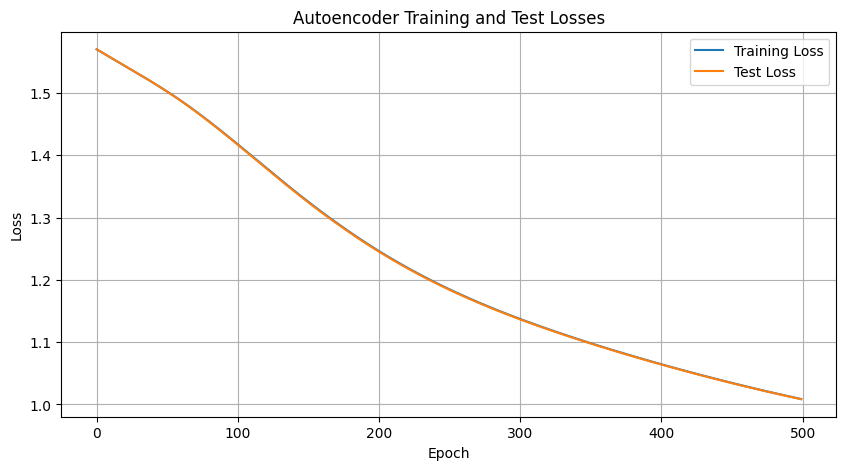

In [45]:

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training and Test Losses')
plt.grid(True)
plt.show()


In [46]:
# Set the threshold for anomaly detection (you can adjust this)
threshold = 0.01

# Define function to detect anomalies
def detect_anomalies(*args):
    # Clear previous output
    output_widget.clear_output()

    # Get input data from widgets
    input_data = [widget.value for widget in input_widgets]
    input_data_encoded = pd.DataFrame([input_data], columns=df_encoded.columns)
    input_data_numeric = input_data_encoded.drop(non_numeric_cols, axis=1)
    input_tensor = torch.tensor(input_data_numeric.values, dtype=torch.float32)

    # Calculate reconstruction error
    model.eval()
    with torch.no_grad():
        reconstructed = model(input_tensor)
        reconstruction_error = torch.mean((input_tensor - reconstructed)**2).item()

    # Display anomaly detection result
    with output_widget:
        if reconstruction_error > threshold:
            print('Anomaly Detected!')
        else:
            print('No Anomaly Detected')

# Create input widgets
input_widgets = [widgets.FloatText(description=col) for col in df_encoded.drop(non_numeric_cols, axis=1).columns]

# Create button to detect anomalies
detect_button = widgets.Button(description='Detect Anomaly')
detect_button.on_click(detect_anomalies)

# Create output widget
output_widget = widgets.Output()

# Display widgets
display(*input_widgets, detect_button, output_widget)

FloatText(value=0.0, description='Amount')

FloatText(value=0.0, description='Merchant_')

FloatText(value=0.0, description='Merchant_merchanta')

FloatText(value=0.0, description='Merchant_merchantb')

FloatText(value=0.0, description='Merchant_merchantc')

FloatText(value=0.0, description='Merchant_merchantd')

FloatText(value=0.0, description='Merchant_merchante')

FloatText(value=0.0, description='Merchant_merchantf')

FloatText(value=0.0, description='Merchant_merchantg')

FloatText(value=0.0, description='Merchant_merchanth')

FloatText(value=0.0, description='Merchant_merchanti')

FloatText(value=0.0, description='Merchant_merchantj')

FloatText(value=0.0, description='TransactionType_')

FloatText(value=0.0, description='TransactionType_purchase')

FloatText(value=0.0, description='TransactionType_transfer')

FloatText(value=0.0, description='TransactionType_withdrawal')

FloatText(value=0.0, description='Location_')

FloatText(value=0.0, description='Location_london')

FloatText(value=0.0, description='Location_los angeles')

FloatText(value=0.0, description='Location_new york')

FloatText(value=0.0, description='Location_san francisco')

FloatText(value=0.0, description='Location_tokyo')

Button(description='Detect Anomaly', style=ButtonStyle())

Output()